## Code for Ai algorithm project

### Production optimization

#### 1. Problem description

- Subject of the probem : to maximize the number of biscuits produced in the same dough.
* constraints : 
    - the roll of dough has a fixed size
    - the roll can have defects that partially usable. Their size is variable, as well as their number and position on the roll.
    - each biscuit is not limited in number in the roll
    - each biscuit has a specific size, value, and a maximum number of defects it can contain

* solution criteria : 
    - be at integer positions, so no half biscuit
    - no overlapping
    - reduce the maximum number of defect in dough as much as possible
    - do not exceed the maximum length of the roll
    - maximize the number of biscuits produced, as well as the value of the biscuits produced

* Benchmark : 
    - length = 500 units
    - set of defects : a, b and c
    - set of biscuits : 
        - biscuit 0 : len = 4, value = 6, max_defect = {a: 4, b: 2, c: 3}
        - biscuit 1 : len = 8, value = 12, max_defect = {a: 5, b: 4, c: 4}
        - biscuit 2 : len = 2, value = 1, max_defect = {a: 1, b: 2, c: 1}
        - biscuit 3 : len = 5, value = 8, max_defect = {a: 2, b: 3, c: 2}

#### Solution 1. using ortools

In [6]:
from ortools.sat.python import cp_model

1. Problem description

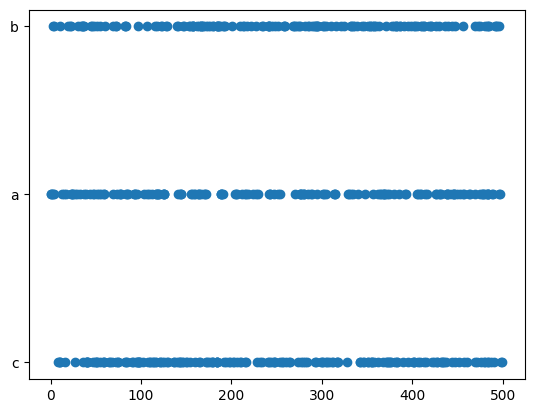

In [7]:
# importation of the defects
import pandas as pd
import matplotlib.pyplot as plt
defects = pd.read_csv("defects.csv", sep = ',')
plt.scatter(defects['x'], defects['class'])


In [8]:
# visualization of the constitutive elements of the defects
defects_sorted = defects.sort_values(by='x')
print(defects_sorted.info())
print(defects_sorted.describe())
print(defects_sorted["class"].value_counts())


<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 479 to 229
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       500 non-null    float64
 1   class   500 non-null    object 
dtypes: float64(1), object(1)
memory usage: 11.7+ KB
None
                x
count  500.000000
mean   246.098987
std    143.914271
min      0.700561
25%    123.001773
50%    242.137840
75%    371.495959
max    499.403445
class
c    177
a    164
b    159
Name: count, dtype: int64


### problem creation

In [9]:
# we define the problem and its variables
problem = cp_model.CpModel()

# we define the variables
# -1 : no biscuit, 0 to 3 : biscuit of type 0 to 3
#to be more efficient, we use one-hot encoding for the biscuit
environnment  = [[problem.NewBoolVar(f"biscuit_no_{i}_pos_{j}")for i in range(-1,4)] for j in range(500)]
print(environnment)

# caution : because of our implementation, 
# a biscuit 0 is not at the indice 0 of the element, but at the indice 1
# a biscuit 1 is not at the indice 1 of the element, but at the indice 2
# a biscuit 2 is not at the indice 2 of the element, but at the indice 3
# a biscuit 3 is not at the indice 3 of the element, but at the indice 4
# indice 0 is for the placeholder biscuit (-what I call biscuit -1)


[[biscuit_no_-1_pos_0(0..1), biscuit_no_0_pos_0(0..1), biscuit_no_1_pos_0(0..1), biscuit_no_2_pos_0(0..1), biscuit_no_3_pos_0(0..1)], [biscuit_no_-1_pos_1(0..1), biscuit_no_0_pos_1(0..1), biscuit_no_1_pos_1(0..1), biscuit_no_2_pos_1(0..1), biscuit_no_3_pos_1(0..1)], [biscuit_no_-1_pos_2(0..1), biscuit_no_0_pos_2(0..1), biscuit_no_1_pos_2(0..1), biscuit_no_2_pos_2(0..1), biscuit_no_3_pos_2(0..1)], [biscuit_no_-1_pos_3(0..1), biscuit_no_0_pos_3(0..1), biscuit_no_1_pos_3(0..1), biscuit_no_2_pos_3(0..1), biscuit_no_3_pos_3(0..1)], [biscuit_no_-1_pos_4(0..1), biscuit_no_0_pos_4(0..1), biscuit_no_1_pos_4(0..1), biscuit_no_2_pos_4(0..1), biscuit_no_3_pos_4(0..1)], [biscuit_no_-1_pos_5(0..1), biscuit_no_0_pos_5(0..1), biscuit_no_1_pos_5(0..1), biscuit_no_2_pos_5(0..1), biscuit_no_3_pos_5(0..1)], [biscuit_no_-1_pos_6(0..1), biscuit_no_0_pos_6(0..1), biscuit_no_1_pos_6(0..1), biscuit_no_2_pos_6(0..1), biscuit_no_3_pos_6(0..1)], [biscuit_no_-1_pos_7(0..1), biscuit_no_0_pos_7(0..1), biscuit_no_1_p

## Constraints

In [10]:
# constraint 1 : the total length of the biscuit must be lower than 500 units
# maximum distance from the end
# biscuit 1 : 3
# biscuit 2 : 7
# biscuit 3 : 1
# biscuit 4 : 4
for i in range(497,500):
    problem.Add(environnment[i][1] == 0)
for i in range(492,500):
    problem.Add(environnment[i][2] == 0)
for i in range(498,500):
    problem.Add(environnment[i][3] == 0)
for i in range(495,500):
    problem.Add(environnment[i][4] == 0)

# constraint 2 : no biscuit should overlapp in the dough
for i in range(500):
   problem.Add(sum(environnment[i]) <= 1) # we could have used a AddDifferent() function

# constraint 3 : the biscuit criteria must be respected
# to do so, we force the value after a biscuit beginning to be of the placeholder biscuit -1 (indice 0)
# so, in binary, a biscuit 1 is reported as [0100,1000,1000,1000] in our environnment
for i in range(500):
    for j in range(1,4):
        if i+j < 500:  # Add this condition to prevent index out of range
            problem.Add(environnment[i+j][0] == 1).OnlyEnforceIf(environnment[i][1])
for i in range(500):
    for j in range(1,8):
        if i+j < 500:  
            problem.Add(environnment[i+j][0] == 1).OnlyEnforceIf(environnment[i][2])
for i in range(500):
    for j in range(1,2):
        if i+j < 500:  
            problem.Add(environnment[i+j][0] == 1).OnlyEnforceIf(environnment[i][3])
for i in range(500):
    for j in range(1,5):
        if i+j < 500:  
            problem.Add(environnment[i+j][0] == 1).OnlyEnforceIf(environnment[i][4])

    


In [11]:
#constraint 4 : the number of defect must be respected
def discrete_count_defects(defect_type, min = 0, max = 500):
    """send back the number of defect contained in the interval [min, max]"""
    counter = 0
    for defect in defects[defects["class"] == defect_type].iterrows():
        x = defect[1]["x"]
        if x > min and x < max:
            counter += 1
    return counter

In [12]:
#for each biscuit, check if the number of defect is lower than the maximum autorised
defect_table = {1 : {"a":4, "b":2, "c":3}, 2 : {"a":5, "b":4, "c":4}, 3 : {"a":1, "b":2, "c":1}, 4 : {"a":2, "b":3, "c":2}}
len_table = {1 : 4, 2 : 8, 3 : 2, 4 : 5}
def count_defects_indiv( biscuit_type):
    for i in range(500):
        """for each biscuit"""
        for let in ["a", "b", "c"]:
            """for each defect"""
            defect = defect_table[biscuit_type][let]
            try : 
                problem.Add(discrete_count_defects(let, i, i+len_table[biscuit_type]) <= defect).OnlyEnforceIf(environnment[i][biscuit_type])
                # problem.AddImplication(environnment[i][biscuit_type], discrete_count_defects(let, i, i+len_table[biscuit_type]) <= defect) # equivalent, but a tad bit slower
                
            except : 
                problem.Add(discrete_count_defects(let, i, 500) <= defect).OnlyEnforceIf(environnment[i][biscuit_type])
                # problem.AddImplication(environnment[i][biscuit_type], discrete_count_defects(let, i, 500) <= defect) # equivalent, but a tad bit slower

for j in range(1,5):
    count_defects_indiv(j)


In [13]:
# what we want to maximize
# goal : have the best value possible

def value(env):
    value = 0
    for i in range(500):
            value += 6*env[i][1] + 12*env[i][2] + 1*env[i][3] + 8*env[i][4]
    return value

problem.Maximize((value(environnment)))


In [30]:
# solve the problem
solver = cp_model.CpSolver()
status = solver.Solve(problem)
if status == cp_model.OPTIMAL:
    print("optimal solution found") # if printed, we know that the solution is the best possible 

optimal solution found


In [31]:
# print the maximum value
print(solver.ObjectiveValue())

760.0


In [32]:
# visualize the solution
solution = []
for i in range(500):
    for j in range(5):
        if solver.Value(environnment[i][j]) == 1:
            solution.append([i, j-1])
print(solution)

[[0, 1], [1, -1], [2, -1], [3, -1], [4, -1], [5, -1], [6, -1], [7, -1], [8, 1], [9, -1], [10, -1], [11, -1], [12, -1], [13, -1], [14, -1], [15, -1], [17, 3], [18, -1], [19, -1], [20, -1], [21, -1], [22, 0], [23, -1], [24, -1], [25, -1], [26, 3], [27, -1], [28, -1], [29, -1], [30, -1], [31, 3], [32, -1], [33, -1], [34, -1], [35, -1], [36, 0], [37, -1], [38, -1], [39, -1], [40, 0], [41, -1], [42, -1], [43, -1], [45, 3], [46, -1], [47, -1], [48, -1], [49, -1], [50, 0], [51, -1], [52, -1], [53, -1], [54, 0], [55, -1], [56, -1], [57, -1], [58, 3], [59, -1], [60, -1], [61, -1], [62, -1], [63, 1], [64, -1], [65, -1], [66, -1], [67, -1], [68, -1], [69, -1], [70, -1], [71, 0], [72, -1], [73, -1], [74, -1], [75, 0], [76, -1], [77, -1], [78, -1], [79, 3], [80, -1], [81, -1], [82, -1], [83, -1], [84, 0], [85, -1], [86, -1], [87, -1], [88, 3], [89, -1], [90, -1], [91, -1], [92, -1], [93, 0], [94, -1], [95, -1], [96, -1], [99, 3], [100, -1], [101, -1], [102, -1], [103, -1], [104, 0], [105, -1], [106

In [34]:
# analyse the number of each biscuit in the roll
biscuits = [0,0,0,0]
for i in range(500):
    for j in range(0,4):
        if solver.Value(environnment[i][j+1]) == 1:
            biscuits[j] += 1 # j-1 because of the placeholder biscuit
print(biscuits)
print(sum(biscuits))

[44, 10, 0, 47]
101


In [35]:
# view the solution in a dataframe
solution = pd.DataFrame(solution, columns = ["x", "biscuit_type"])
solution

,x,biscuit_type
0,0,1
1,1,-1
2,2,-1
3,3,-1
4,4,-1
...,...,...
487,495,-1
488,496,0
489,497,-1
490,498,-1


In [37]:
# check if the deflect criteria are respected
def defect_checker(solution):
    """send the biggest defect for each biscuit and each type of defects"""
    possible_solution = solution.copy()
    possible_solution["biscuit_type"] = possible_solution["biscuit_type"] + 1 # because of the placeholder biscuit, again
    max_number_of_defects = {1 : {"a":0, "b":0, "c":0}, 2 : {"a":0, "b":0, "c":0}, 3 : {"a":0, "b":0, "c":0}, 4 : {"a":0, "b":0, "c":0}}
    indice = possible_solution["x"].tolist() # The case without anything (even a placeholder biscuit) are not listed, making the len function irrelevant here
    max_indice = max(indice)
    for i in indice:
        """for each position"""
        for type in range(1,5):
            """for each biscuit"""
            if possible_solution[possible_solution["x"] == i]["biscuit_type"].tolist()[0] == type:
                try : 
                    a = discrete_count_defects("a", i, i+len_table[type])
                    b = discrete_count_defects("b", i, i+len_table[type])
                    c = discrete_count_defects("c", i, i+len_table[type])
                except : # in case we are at the end of the roll
                    a = discrete_count_defects("a", i, max_indice)
                    b = discrete_count_defects("b", i, max_indice)
                    c = discrete_count_defects("c", i, max_indice)
                if a > max_number_of_defects[type]["a"]:
                    max_number_of_defects[type]["a"] = a
                if b > max_number_of_defects[type]["b"]:
                    max_number_of_defects[type]["b"] = b
                if c > max_number_of_defects[type]["c"]:
                    max_number_of_defects[type]["c"] = c
                if a > defect_table[type]["a"] or b > defect_table[type]["b"] or c > defect_table[type]["c"]:
                    print("defect criteria not respected")
                    print("place :",i)
                    print("biscuit type :", type)
    return max_number_of_defects
print(defect_checker(solution))

{1: {'a': 4, 'b': 2, 'c': 3}, 2: {'a': 5, 'b': 4, 'c': 4}, 3: {'a': 0, 'b': 0, 'c': 0}, 4: {'a': 2, 'b': 3, 'c': 2}}


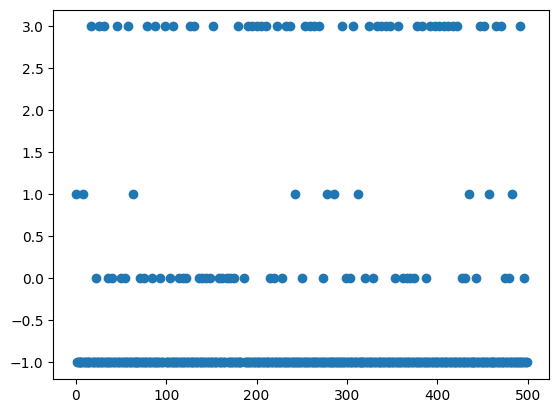

In [38]:
#plot the solution

plt.plot(solution['x'], solution["biscuit_type"], 'o')
plt.show()

## summary

- time to calculate : 16s to charge every constraints, 0.1s to solve the problem

- number of biscuit produced : 101

- value of biscuit produced : 760

- criteria are respected, as seen by the function defect_checker

- the solution is optimal